# Detect Emergency Vehicles - Transfer learning

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
import random
from shutil import copyfile
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

### Getting the data

Data has been provided by the organizers of the hackathon :
https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon/


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!ls "/content/drive/My Drive/BigData2020/data"
dirPath = "/content/drive/My Drive/Colab Notebooks/AV/AV_Janata_Hack_3/data/train/"
#%ls -l "$dirPath" # Get the content of the directory in long format (note the '$')

In [0]:
#Source - https://gist.github.com/bertcarremans/679624f369ed9270472e37f8333244f5
def img_train_test_split(img_source_dir, train_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('data'):
        os.makedirs('data')
    if not os.path.exists('data/train'):
        os.makedirs('data/train')
    if not os.path.exists('data/validation'):
        os.makedirs('data/validation')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('data/train', subdir)
        validation_subdir = os.path.join('data/validation', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        train_counter = 0
        validation_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to data/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to data/validation/' + subdir)

In [12]:
img_train_test_split(dirPath,0.80)

Copied 786 images to data/train/0
Copied 179 images to data/validation/0
Copied 520 images to data/train/1
Copied 161 images to data/validation/1


In [0]:
train=pd.read_csv(dirPath+'train.csv', index_col='image_names')
test=pd.read_csv(dirPath+'test.csv', index_col='image_names')

In [0]:
labels = list(train['emergency_or_not'].unique())

for label in labels:
  try:
    os.makedirs('./drive/My Drive/Colab Notebooks/AV/AV_Janata_Hack_3/data/train/'+str(label))
  except:
    print('Directory already exists/ Error in creation')

In [0]:
for image in train.index:
  folder = train.loc[image, 'emergency_or_not']
  src = './drive/My Drive/Colab Notebooks/AV/AV_Janata_Hack_3/'+'images/{}'.format(image)
  dst = './drive/My Drive/Colab Notebooks/AV/AV_Janata_Hack_3/data/train/{}/{}'.format(folder, image)
  try:
    copyfile(src, dst)
  except:
    print('Could not copy {} - {}'.format(image,folder))

In [0]:
for image in test.index:
  src = './drive/My Drive/Colab Notebooks/AV/AV_Janata_Hack_3/'+'images/{}'.format(image)
  dst = './drive/My Drive/Colab Notebooks/AV/AV_Janata_Hack_3/data/test/{}'.format(image)
  try:
    copyfile(src, dst)
  except:
    print('Could not copy {} - {}'.format(image,folder))

### Standardizing the data and Augmentation

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer
values between 0 and 255 (RGB level values). This isn't a great fit for feeding a
 neural network. We need to do 2 things:

- Standardize to a fixed image size. We pick 224X224.
- Normalize pixel values between -1 and 1. We'll do this using a `Normalization` layer as
 part of the model itself.

Here, we'll do image resizing in the data pipeline (because a deep neural network can
only process contiguous batches of data), and we'll do the input value scaling as part
 of the model, when we create it.

In [5]:
train_dir='./data/train/'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1306 images belonging to 2 classes.


In [6]:
validation_dir='./data/validation/'

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 340 images belonging to 2 classes.


### Building the model using pre-trained VGG16 model on Imagenet

In [33]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()
# make a reference to VGG's input layer
inp = vgg.input
num_classes=2

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(1, activation='sigmoid')

# connect our new layer to the second to last layer in VGG, and make a reference to it

out = layers.Dropout(0.3)(vgg.layers[-2].output)
out = new_classification_layer(out)
# create a new network between inp and out
model = Model(inp, out)

# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model.layers[-1:]):
    layer.trainable = True

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

####Training

In [34]:
epochs = 20
batch_size=20
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs, 
                    verbose=1,
                    steps_per_epoch=1306//batch_size, # batch size of 20 is defined in generator, so 2000/20 training batches
                    validation_steps=340//batch_size,callbacks=[callback])
model.save_weights('best_model.h5') 

Epoch 1/20
65/65 [==============================] - 17s 260ms/step - loss: 0.6629 - accuracy: 0.6236 - val_loss: 0.4861 - val_accuracy: 0.7912
Epoch 2/20
65/65 [==============================] - 17s 255ms/step - loss: 0.5330 - accuracy: 0.7325 - val_loss: 0.4467 - val_accuracy: 0.7706
Epoch 3/20
65/65 [==============================] - 17s 259ms/step - loss: 0.4999 - accuracy: 0.7652 - val_loss: 0.4342 - val_accuracy: 0.7647
Epoch 4/20
65/65 [==============================] - 16s 251ms/step - loss: 0.4921 - accuracy: 0.7589 - val_loss: 0.4805 - val_accuracy: 0.7441
Epoch 5/20
65/65 [==============================] - 17s 257ms/step - loss: 0.4593 - accuracy: 0.7776 - val_loss: 0.4066 - val_accuracy: 0.8206
Epoch 6/20
65/65 [==============================] - 17s 257ms/step - loss: 0.4472 - accuracy: 0.8033 - val_loss: 0.3430 - val_accuracy: 0.8824
Epoch 7/20
65/65 [==============================] - 17s 255ms/step - loss: 0.4464 - accuracy: 0.7970 - val_loss: 0.3320 - val_accuracy: 0.8618

In [0]:
models_path='/content/drive/My Drive/Colab Notebooks/AV/AV_Janata_Hack_3/models/'
if not os.path.exists(models_path):
    os.makedirs(models_path)
    model.save_weights(models_path+'best_model.h5') 

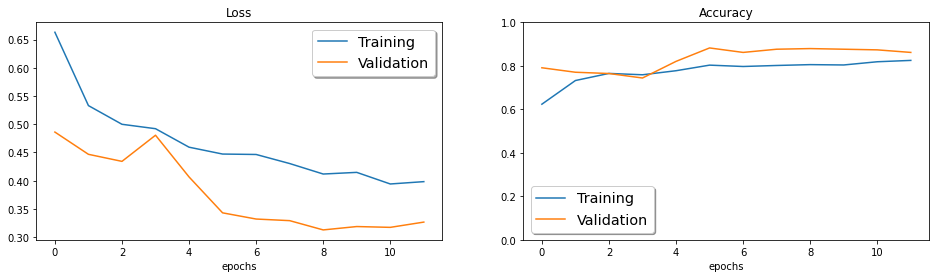

In [36]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["loss"],label='Training')
ax.plot(history.history["val_loss"],label='Validation')
legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
ax.set_title("Loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"],label='Training')
ax2.plot(history.history["val_accuracy"],label='Validation')
legend = ax2.legend(loc='best', shadow=True, fontsize='x-large')
ax2.set_title("Accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [12]:
test_dir='./drive/My Drive/Colab Notebooks/AV/AV_Janata_Hack_3/data/.'
test_datagen = ImageDataGenerator(
    rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=1,class_mode='binary',classes=['test']
        # Since we use binary_crossentropy loss, we need binary labels),
)

Found 706 images belonging to 1 classes.


In [0]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [0]:
try:
  predictions = model.predict(test_generator,steps = nb_samples)
except:
  print('Damn!')

In [0]:
predictions_df=pd.DataFrame(data=filenames, columns=["image_names"])
predictions_df["image_names"]=predictions_df["image_names"].str.replace("test/","")
predictions_df['prediction']=predictions
threshold=0.5
predictions_df['emergency_or_not']=['1' if x >= threshold else '0' for x in predictions_df['prediction']]

In [0]:
predictions_df.to_csv('submission.csv')

####Fine Tuning model

In [37]:
# ensure all the layers are trainable/not frozen
for l, layer in enumerate(model.layers):
    layer.trainable = True

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [38]:
epochs = 5
batch_size=20
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs, 
                    verbose=1,
                    steps_per_epoch=1306//batch_size, # batch size of 20 is defined in generator, so 2000/20 training batches
                    validation_steps=340//batch_size,callbacks=[callback])
model.save_weights('best_model_tuned.h5') 

Epoch 1/5
65/65 [==============================] - 20s 307ms/step - loss: 0.4585 - accuracy: 0.8056 - val_loss: 0.1933 - val_accuracy: 0.9265
Epoch 2/5
65/65 [==============================] - 20s 304ms/step - loss: 0.2454 - accuracy: 0.8974 - val_loss: 0.1804 - val_accuracy: 0.9324
Epoch 3/5
65/65 [==============================] - 19s 300ms/step - loss: 0.2003 - accuracy: 0.9238 - val_loss: 0.1956 - val_accuracy: 0.9294
Epoch 4/5
65/65 [==============================] - 20s 302ms/step - loss: 0.2008 - accuracy: 0.9160 - val_loss: 0.1438 - val_accuracy: 0.9529
Epoch 5/5
65/65 [==============================] - 19s 297ms/step - loss: 0.1751 - accuracy: 0.9355 - val_loss: 0.2334 - val_accuracy: 0.9147


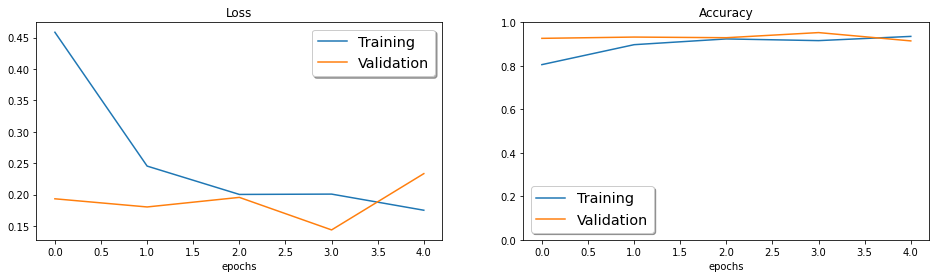

In [40]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["loss"],label='Training')
ax.plot(history.history["val_loss"],label='Validation')
legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
ax.set_title("Loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"],label='Training')
ax2.plot(history.history["val_accuracy"],label='Validation')
legend = ax2.legend(loc='best', shadow=True, fontsize='x-large')
ax2.set_title("Accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [0]:
try:
  predictions = model.predict(test_generator,steps = nb_samples)
except:
  print('Damn!')

In [0]:
predictions_df=pd.DataFrame(data=filenames, columns=["image_names"])
predictions_df["image_names"]=predictions_df["image_names"].str.replace("test/","")
predictions_df['prediction']=predictions
threshold=0.5
predictions_df['emergency_or_not']=['1' if x >= threshold else '0' for x in predictions_df['prediction']]
predictions_df.drop(columns="prediction",inplace=True)

In [0]:
predictions_df.to_csv('submission.csv',index=False)